### Reading Data

In [1]:

from fncs import significantCorrelations
from custom_functions import filter_outliers, load_hdf5
from tkinter import filedialog
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

path = filedialog.askdirectory()
file_list = os.listdir(path)
file_names = [os.path.splitext(f)[0] for f in file_list if f.endswith(".hdf5")]

# dfs = [load_hdf5(path + "/" + file) for file in file_list if file.endswith(".hdf5")]
dfs = []
for i in range(len(file_list)):
    if file_list[i].endswith(".hdf5"):
        dfs.append(load_hdf5(path + "/" + file_list[i]))


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Plotting Data

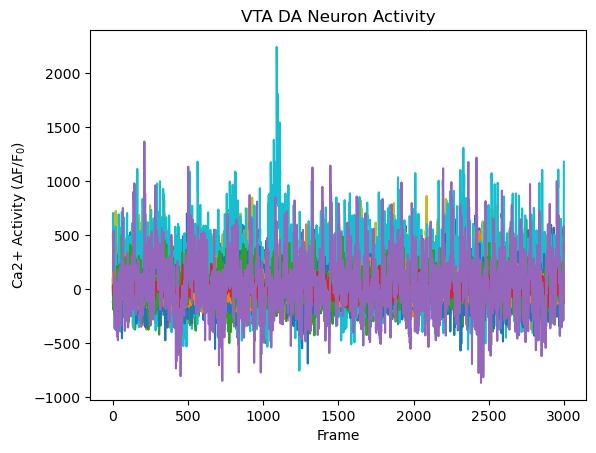

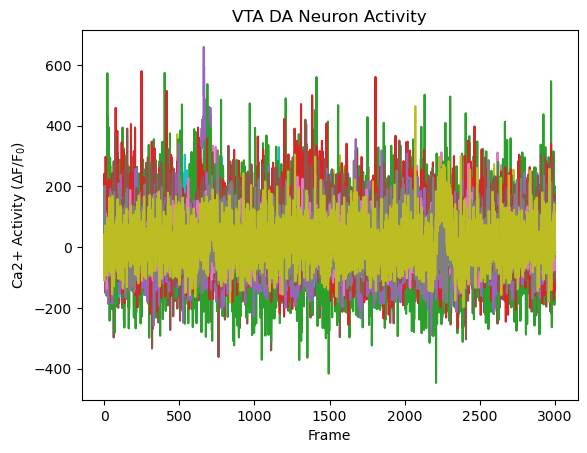

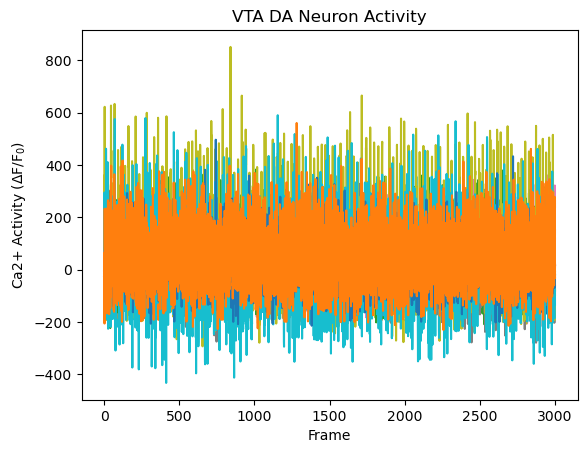

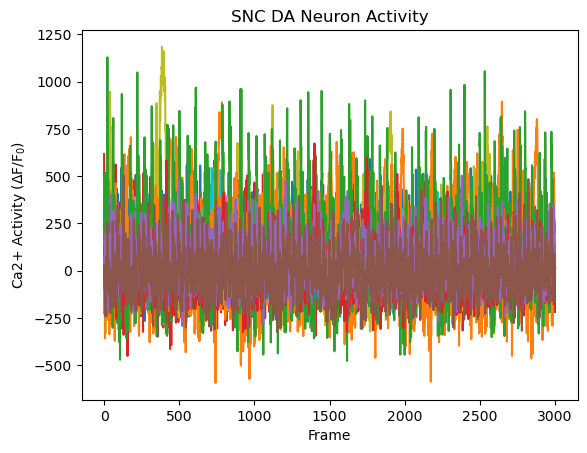

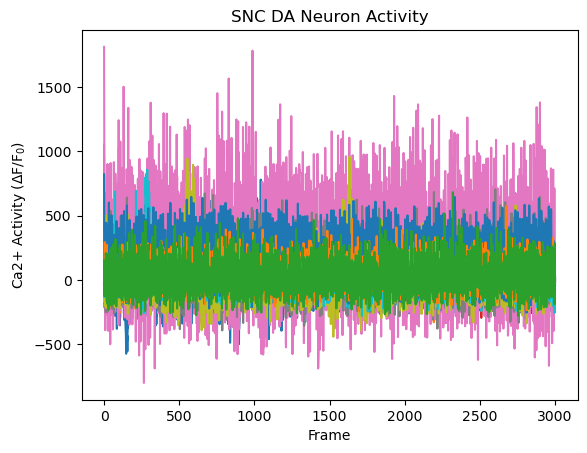

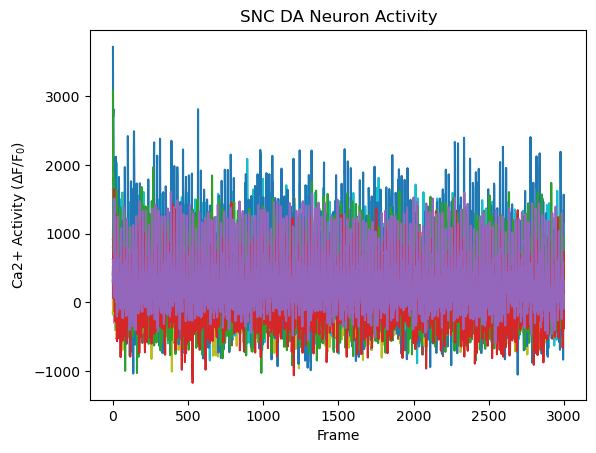

In [2]:
from custom_functions import plot_by_frame, plot_by_frame_old

for df_i in range(len(dfs)):
    if "VTA" in file_names[df_i].upper():
        plot_by_frame_old(dfs[df_i], np.arange(0, dfs[df_i].shape[1]), 'VTA DA Neuron Activity')
    elif "SNC" in file_names[df_i].upper():
        plot_by_frame_old(dfs[df_i], np.arange(0, dfs[df_i].shape[1]), 'SNC DA Neuron Activity')
    else:
        plot_by_frame_old(dfs[df_i], np.arange(0, dfs[df_i].shape[1]), "DF: " + str(df_i) + ' Neuron Activity')

### Filtering Data

Data Loss due to filtering: 2.6%


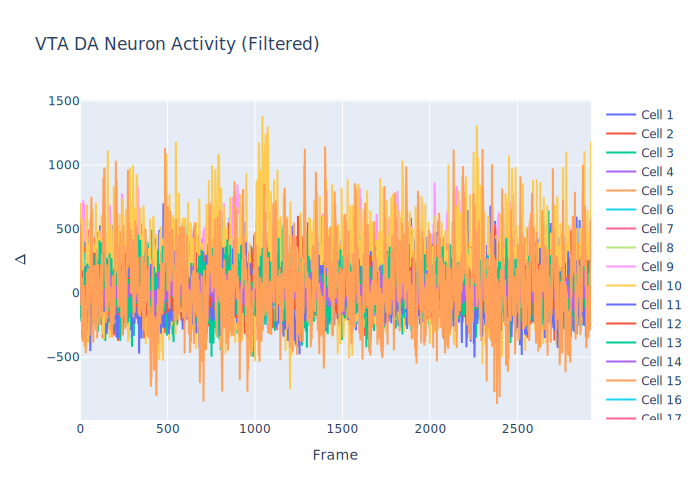

Data Loss due to filtering: 7.17%


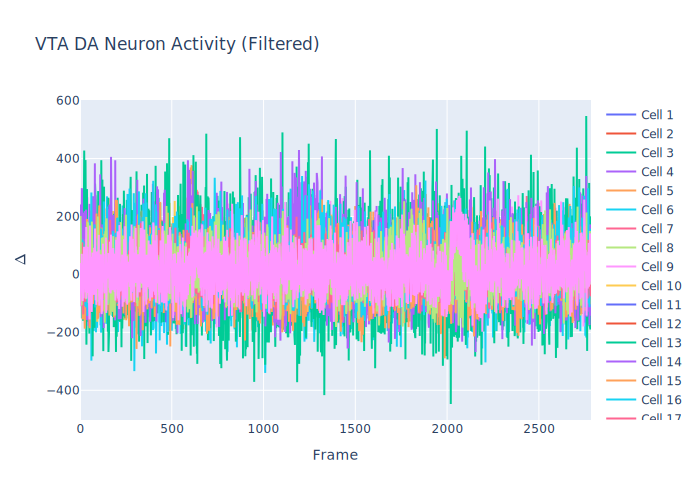

Data Loss due to filtering: 2.77%


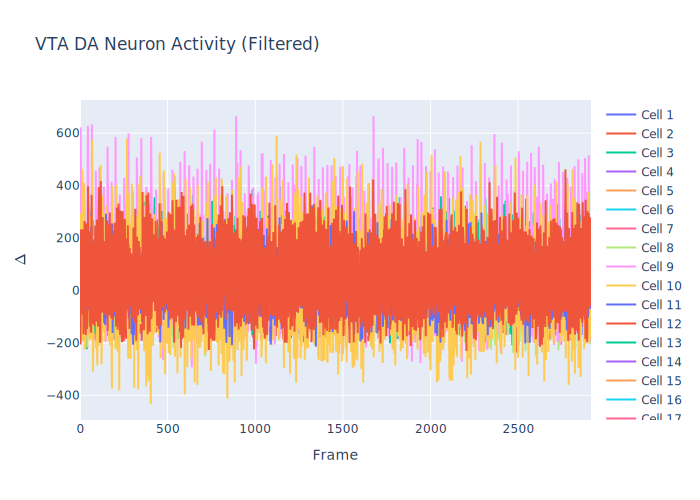

Data Loss due to filtering: 6.47%


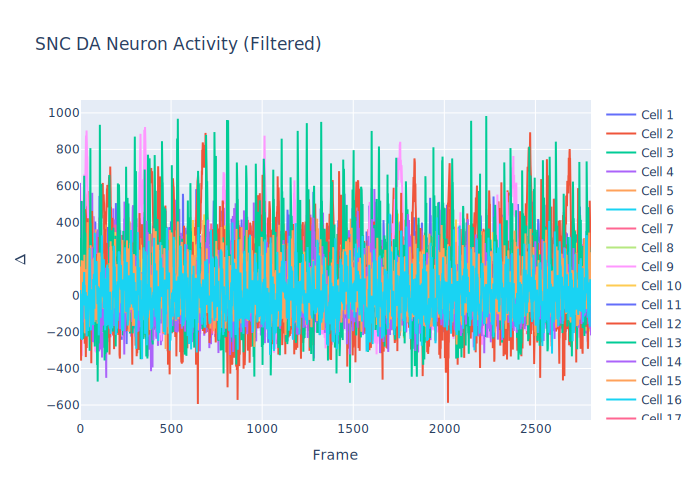

Data Loss due to filtering: 6.03%


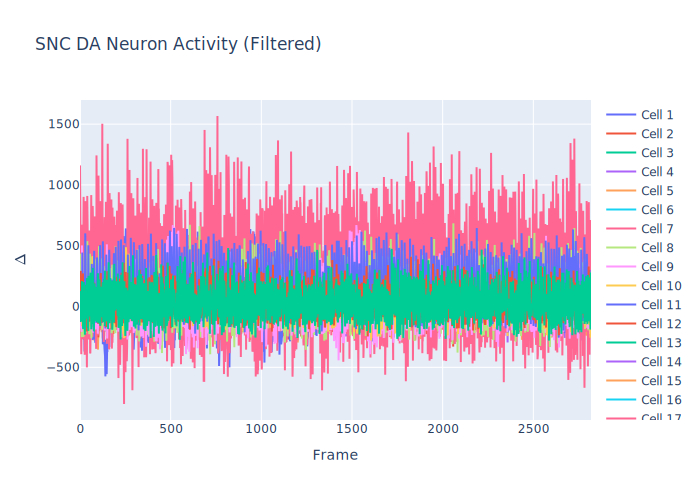

Data Loss due to filtering: 2.43%


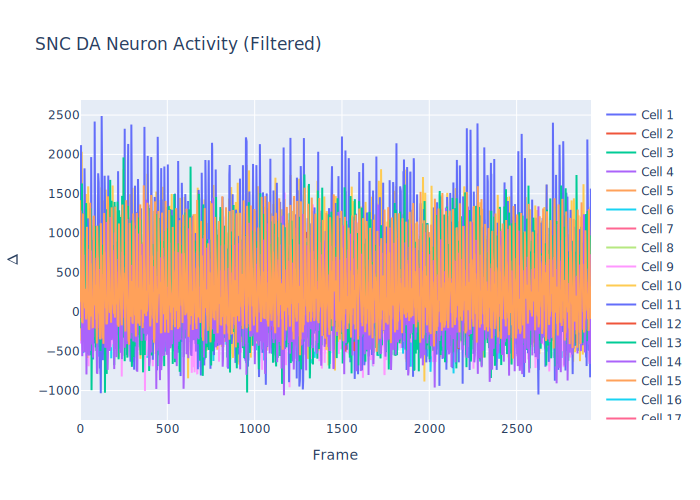

In [3]:
import pandas as pd
from custom_functions import filter_outliers

pd_dfs = [pd.DataFrame(df).T for df in dfs]


VTA_indexes = []
SNC_indexes = []
filtered_dfs = []

for df_i in range(len(pd_dfs)):
    filtered_df = filter_outliers(pd_dfs[df_i], 3.8)
    if "VTA" in file_names[df_i].upper():
        plot_by_frame(filtered_df.T.to_numpy(), np.arange(0, filtered_df.shape[0]), 'VTA DA Neuron Activity (Filtered)')
        VTA_indexes.append(df_i)


    elif "SNC" in file_names[df_i].upper():
        plot_by_frame(filtered_df.T.to_numpy(), np.arange(0, filtered_df.shape[0]), 'SNC DA Neuron Activity (Filtered)')
        SNC_indexes.append(df_i)

    filtered_dfs.append(filtered_df.T.to_numpy())

### Random Sampling

In [4]:
def avg_n_sample_means(data, cell_num):
    colnum = pd.DataFrame(data).shape[1]
    sample_sum = pd.DataFrame([[0] * colnum] * cell_num)
    for i in range(20): # Central Limit Theorem n >= 20
        selection = pd.DataFrame(data).sample(n=cell_num, axis="rows").to_numpy()
        sample_sum = sample_sum + selection
    return (sample_sum / 20).to_numpy()    

In [5]:
min_index = min(len(VTA_indexes), len(SNC_indexes))

cell_nums_select = []
for df_i in range(min_index):
    cell_nums_select.append(min(filtered_dfs[VTA_indexes[df_i]].shape[0], filtered_dfs[SNC_indexes[df_i]].shape[0]))
    print(avg_n_sample_means(filtered_dfs[VTA_indexes[df_i]], 20).shape)

cell_nums_select

(20, 2922)
(20, 2785)
(20, 2917)


[25, 39, 22]

In [6]:
final_dfs = []
SNC_i = 0
VTA_i = 0

for df_i in range(len(filtered_dfs)):
    if "VTA" in file_names[df_i].upper():
        new_df = avg_n_sample_means(filtered_dfs[df_i], cell_nums_select[VTA_i])
        final_dfs.append(new_df)
        VTA_i+=1 

    elif "SNC" in file_names[df_i].upper():
        new_df = avg_n_sample_means(filtered_dfs[df_i], cell_nums_select[SNC_i])
        final_dfs.append(new_df)
        SNC_i+=1 

### Plotting Significant Correlations

In [13]:
from custom_functions import get_corr_figure
from fncs import significantCorrelations, nonnegativeMatrix

adjacency_matrices = [nonnegativeMatrix(significantCorrelations(df, "spearman")[0]) for df in final_dfs]
correlations = [significantCorrelations(df, "spearman")[1] for df in final_dfs]

The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22
The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22
The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22
The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22


The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22


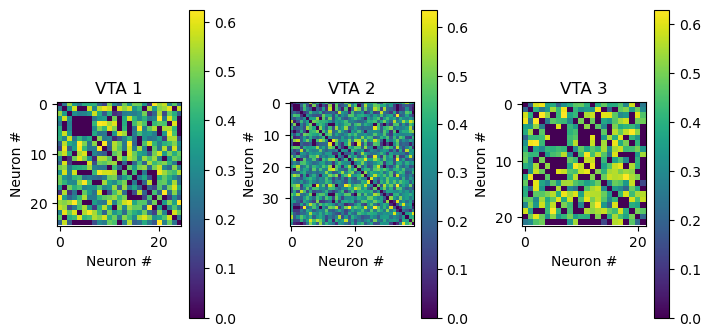

The number of cells in the dataset is 25
The number of cells in the dataset is 39
The number of cells in the dataset is 22


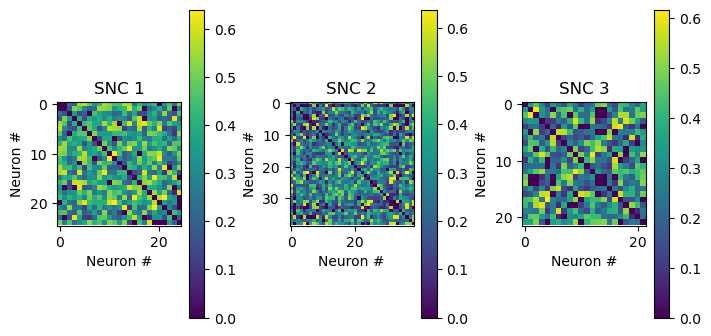

In [14]:

fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Iterate over the adjacency matrices and plot the heatmaps
for i, index in enumerate(VTA_indexes):
    # Calculate the row and column indices for the current subplot
    col = i % 4

    # Plot the heatmap
    im = axs[col].imshow(significantCorrelations(final_dfs[index], "spearman")[0])
    axs[col].set_title(f'VTA {i+1}')
    axs[col].set_xlabel('Neuron #')
    axs[col].set_ylabel('Neuron #')

    cbar = fig.colorbar(im, ax=axs[col])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(8, 4))

# Iterate over the adjacency matrices and plot the heatmaps
for i, index in enumerate(SNC_indexes):
    # Calculate the row and column indices for the current subplot
    col = i % 4

    # Plot the heatmap
    im = axs[col].imshow(significantCorrelations(final_dfs[index], "spearman")[0])
    axs[col].set_title(f'SNC {i+1}')
    axs[col].set_xlabel('Neuron #')
    axs[col].set_ylabel('Neuron #')

    cbar = fig.colorbar(im, ax=axs[col])

    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
plt.show()


### Functional Connectivity

#### Dynamic Functional Connectivity

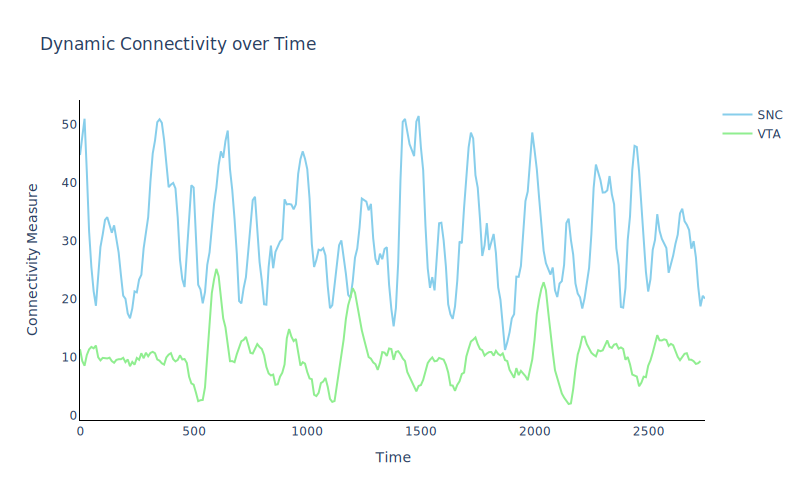

In [20]:
import plotly.graph_objects as go
import numpy as np

box_colors = ["skyblue", "lightgreen"]

data1 = final_dfs[3].T
data2 = final_dfs[1].T

VTA_indexes = []
SNC_indexes = []

for df_i in range(len(dfs)):
    if "VTA" in file_names[df_i].upper():
        VTA_indexes.append(df_i)
    elif "SNC" in file_names[df_i].upper():
        SNC_indexes.append(df_i)

# Define sliding window parameters
window_size = 50
step_size = 10

def calculate_dynamic_connectivity(data):
    n_windows = int((data.shape[0] - window_size) / step_size) + 1
    dynamic_connectivity = np.zeros(n_windows)

    for i in range(n_windows):
        start = i * step_size
        end = start + window_size

        window_data = data[start:end, :]
        connectivity_measure = np.mean(window_data)
        dynamic_connectivity[i] = connectivity_measure

    return dynamic_connectivity

dynamic_connectivity1 = calculate_dynamic_connectivity(data1)
dynamic_connectivity2 = calculate_dynamic_connectivity(data2)

trace1 = go.Scatter(
    x=np.arange(dynamic_connectivity1.shape[0]) * step_size,
    y=dynamic_connectivity1,
    name="SNC",
    line=dict(color=box_colors[0])
)

trace2 = go.Scatter(
    x=np.arange(dynamic_connectivity2.shape[0]) * step_size,
    y=dynamic_connectivity2,
    name="VTA",
    line=dict(color=box_colors[1])
)

layout = go.Layout(
    title="Dynamic Connectivity over Time",
    xaxis=dict(title="Time", showline=True, linewidth=1, linecolor='black'),
    yaxis=dict(title="Connectivity Measure", showline=True, linewidth=1, linecolor='black'),
    showlegend=True,
    plot_bgcolor='white',
    width=800,
    height=500
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show("svg")


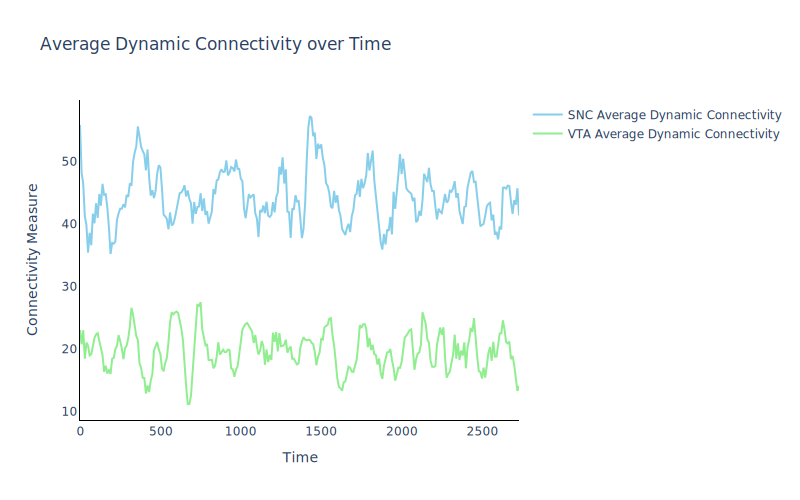

In [19]:
VTA_dynamic_connectivities_sum = 0
SNC_dynamic_connectivities_sum = 0

dc_lengths = []

for i in range(len(final_dfs)):
    dc_lengths.append(calculate_dynamic_connectivity(final_dfs[i].T).shape[0])

min_dc_length = min(dc_lengths)

VTA_count = 0
SNC_count = 0

for df_i in range(len(final_dfs)):
    if "VTA" in file_names[df_i].upper():
        VTA_dynamic_connectivities_sum = VTA_dynamic_connectivities_sum + calculate_dynamic_connectivity(filtered_dfs[df_i].T)[:min_dc_length]
        VTA_count += 1

    elif "SNC" in file_names[df_i].upper():
        SNC_dynamic_connectivities_sum = SNC_dynamic_connectivities_sum + calculate_dynamic_connectivity(filtered_dfs[df_i].T)[:min_dc_length]
        SNC_count += 1


VTA_dc_average = VTA_dynamic_connectivities_sum / len(VTA_indexes)
SNC_dc_average = SNC_dynamic_connectivities_sum / len(SNC_indexes)

trace1 = go.Scatter(
    x=np.arange(min_dc_length) * step_size,
    y=SNC_dc_average,
    name="SNC Average Dynamic Connectivity",
    line=dict(color=box_colors[0])
)

trace2 = go.Scatter(
    x=np.arange(min_dc_length) * step_size,
    y=VTA_dc_average,
    name="VTA Average Dynamic Connectivity",
    line=dict(color=box_colors[1])
)

layout = go.Layout(
    title="Average Dynamic Connectivity over Time",
    xaxis=dict(title="Time", showline=True, linewidth=1, linecolor='black'),
    yaxis=dict(title="Connectivity Measure", showline=True, linewidth=1, linecolor='black'),
    showlegend=True,
    plot_bgcolor='white',
    width=800,
    height=500
)

fig = go.Figure(data=[trace1, trace2], layout=layout)
fig.show("svg")


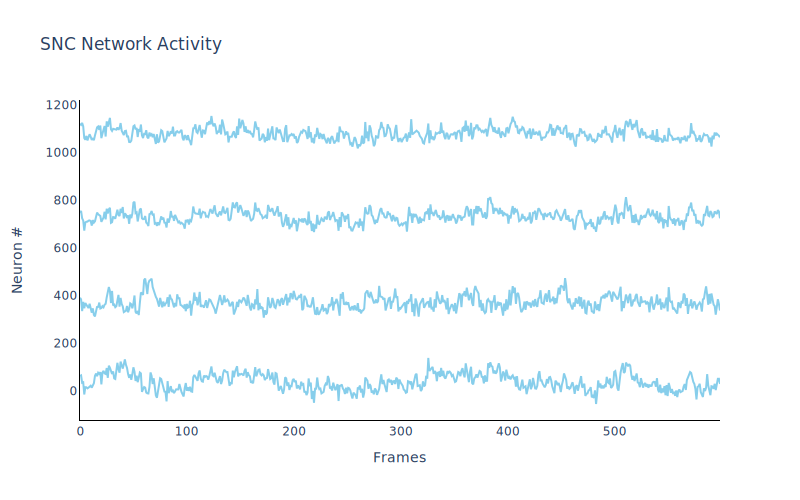

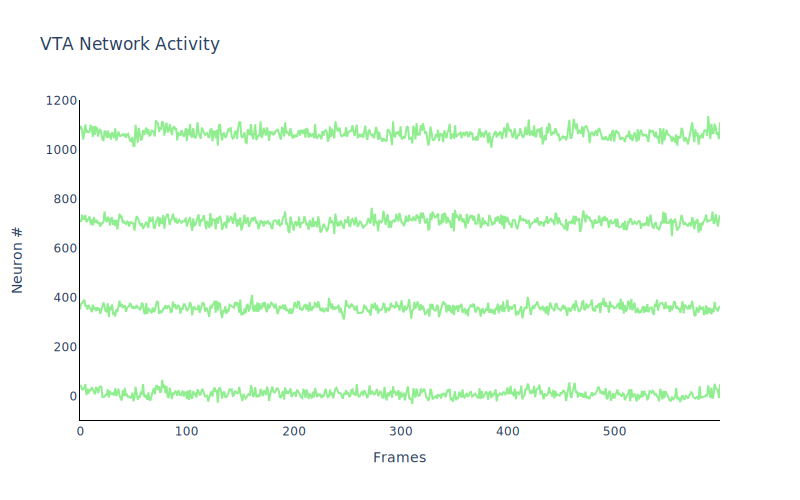

In [18]:
import pandas as pd
import plotly.graph_objects as go

selected_dfs = [pd.DataFrame(final_dfs[3].T), pd.DataFrame(final_dfs[1].T)]

cells_to_plot = [0, 1, 2, 3]


j = 0
for df in selected_dfs:
    fig = go.Figure()

    if j == 0:
        Title = "SNC Network Activity"
        ci = 0
    else:
        Title = "VTA Network Activity"
        ci = 1

    for i, cell in enumerate(cells_to_plot):
        y = df[cell][:600] + i * 350
        fig.add_trace(go.Scatter(x=df.index[:600], y=y, mode='lines', name="Cell " + str(cell + 1), line=dict(color=box_colors[ci])))


    fig.update_layout(
        autosize=False,
        height=500,
        width=800,
        title=Title,
        xaxis=dict(title="Frames", showline=True, linewidth=1, linecolor='black'),
        yaxis=dict(title="Neuron #", showline=True, linewidth=1, linecolor='black'),
        showlegend=False,
        plot_bgcolor = "white"
    )

    fig.show("svg")
    j +=1


#### Regional Functional Connectivity

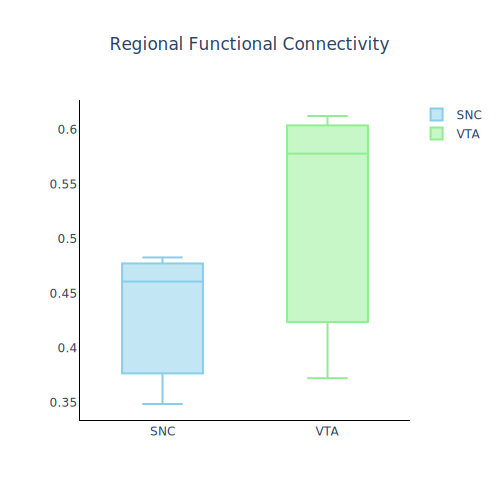

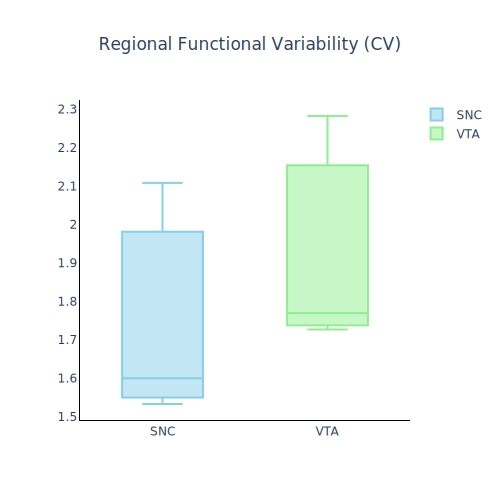

In [22]:
VTA_functional_C = []
SNC_functional_C = []

VTA_functional_variability = []
SNC_functional_variability = []

for i in range(len(dfs)):
    if "VTA" in file_names[i].upper():
        adj = adjacency_matrices[i]
        corr = correlations[i]
        avg = corr.sum() / adj[adj!=0].size
        VTA_functional_C.append(avg)
        var_coef = adj.mean() / adj.std()
        VTA_functional_variability.append(var_coef)

    elif "SNC" in file_names[i].upper():
        adj = adjacency_matrices[i]
        corr = correlations[i]
        avg = corr.sum() / adj[adj!=0].size
        SNC_functional_C.append(avg)
        var_coef = adj.mean() / adj.std()
        SNC_functional_variability.append(var_coef)



data = [SNC_functional_C, VTA_functional_C]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    title='Regional Functional Connectivity',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")


data = [SNC_functional_variability, VTA_functional_variability]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(showline=True, linewidth=1, linecolor='black'),
    title= 'Regional Functional Variability (CV)',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")


### Normalized Node Strength Comparison

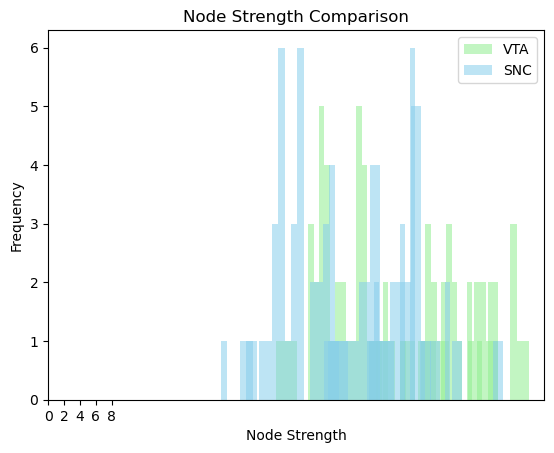

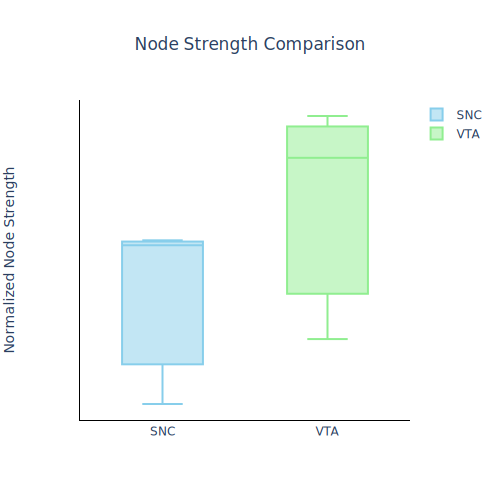

In [23]:
from fncs import nodeStrength
import matplotlib.pyplot as plt

nnss = [nodeStrength(aMatrix) for aMatrix in correlations]
vflag = False
sflag = False
VTA_ns = []
SNC_ns = []

# plt.figure(figsize=(6,6))
for i in range(len(nnss)):
    if "VTA" in file_names[i].upper():
        VTA_ns.append(nnss[i][1].mean())
        if not vflag:
            plt.hist(nnss[i][1], bins=25, alpha=0.55, color=box_colors[1], label="VTA")
            vflag = True 
        else:
            plt.hist(nnss[i][1], bins=25, alpha=0.55, color=box_colors[1], label='_nolegend_')


    elif "SNC" in file_names[i].upper():
        SNC_ns.append(nnss[i][1].mean())
        if not sflag:
            plt.hist(nnss[i][1], bins=25, alpha=0.55, color=box_colors[0], label="SNC")
            sflag = True
        else:
            plt.hist(nnss[i][1], bins=25, alpha=0.55, color=box_colors[0], label='_nolegend_')
            
plt.xlabel("Node Strength")
plt.ylabel("Frequency")
plt.title("Node Strength Comparison")
tick_values = [0.0, 0.02, 0.04, 0.06, 0.08]
tick_labels = ['0', '2', '4', '6', '8']

# Set the tick locations and labels for the x-axis
plt.xticks(tick_values, tick_labels)
plt.grid(False)
plt.legend()

fig = plt.gcf()
fig.patch.set_facecolor('white')

plt.show()

data = [SNC_ns, VTA_ns]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Normalized Node Strength',
        tickmode='array',
        ticktext=['2', '3', '4', '5'],  # Specify the desired tick labels
        tickvals=[0.02, 0.03, 0.04, 0.05],  # Specify the corresponding tick values
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Node Strength Comparison',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")


5


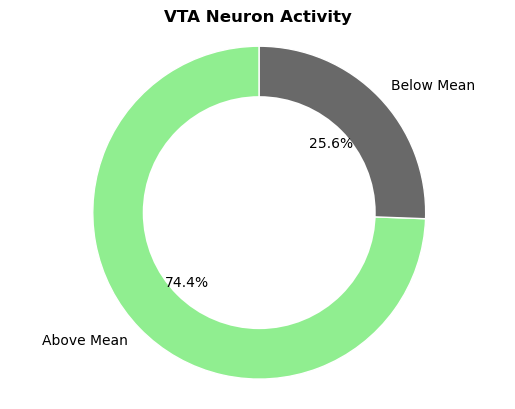

5


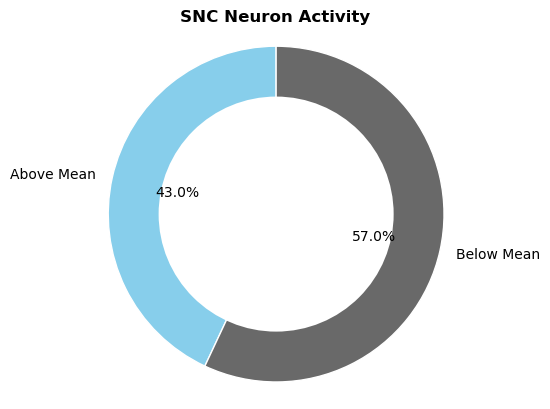

In [42]:
# from custom_functions import pie_chart_above_mean

colormap_snc = [box_colors[0], "dimgray"]
colormap_vta = [box_colors[1], "dimgray"]


def pie_chart_above_mean(data, indexes, plot_title, color_map):
    global means

    above_mean_count = 0
    below_mean_count = 0

    means = []    

    for i in range(len(data)):
        values = data[i][0].flatten()
        mean_value = np.mean(values)
        means.append(mean_value)
    print(i)

    ns_mean = np.mean(means)

    for i in indexes:
        values = data[i][0].flatten()

        above_mean_count += np.sum(values > ns_mean)
        below_mean_count += np.sum(values < ns_mean)

    labels = ['Above Mean', 'Below Mean']
    sizes = [above_mean_count, below_mean_count]

    colors = ['#ff9999', '#66b3ff']

    fig, ax = plt.subplots()
    ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=color_map, startangle=90,
        wedgeprops={'edgecolor': 'white'})

    center_circle = plt.Circle((0, 0), 0.70, fc='white')
    fig.gca().add_artist(center_circle)

    ax.axis('equal')

    # Add a title
    plt.title(plot_title, fontweight='bold')

    # Display the pie chart
    plt.show()

pie_chart_above_mean(nnss, VTA_indexes, 'VTA Neuron Activity', colormap_vta)
pie_chart_above_mean(nnss, SNC_indexes, 'SNC Neuron Activity', colormap_snc)



## Network Measures

### Assortativity

VTA Network Assortativity: -0.2072241809901684
VTA Network Assortativity: -0.07004334930400889
VTA Network Assortativity: -0.11382960060814482
SNC Network Assortativity: -0.12647509280170097
SNC Network Assortativity: -0.06179656716158987
SNC Network Assortativity: -0.14771111742962859


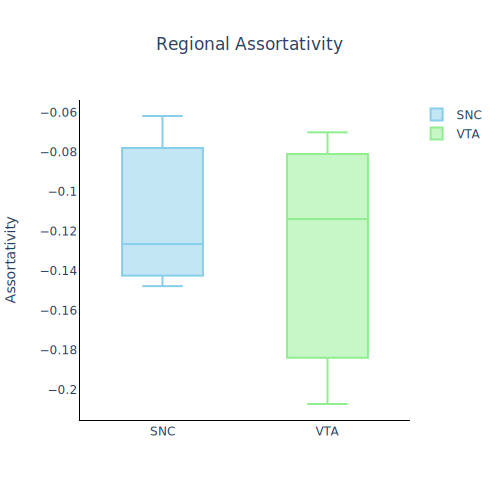

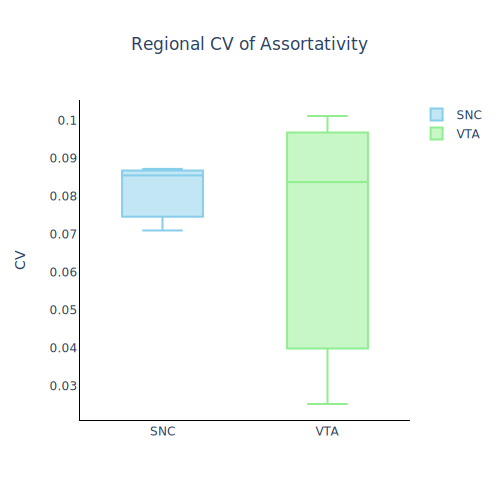

In [24]:
from fncs import nonnegativeMatrix
import networkx as nx
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

VTAs_assortativity = []
SNCs_assortativity = []

VTAs_assortativity_cv = []
SNCs_assortativity_cv = []

for i in range(len(dfs)):
    G = nx.from_numpy_array(adjacency_matrices[i])
    
    assortativity = nx.degree_assortativity_coefficient(G)
    if "VTA" in file_names[i].upper():
        print("VTA Network Assortativity:", assortativity)
        VTAs_assortativity.append(assortativity)

    elif "SNC" in file_names[i].upper():
        print("SNC Network Assortativity:", assortativity)
        SNCs_assortativity.append(assortativity)


    region_assortativity = np.array(G.degree()).T[1]  # Extract node degrees
    region_cv = np.std(region_assortativity) / np.mean(region_assortativity)
    if "VTA" in file_names[i].upper():
        VTAs_assortativity_cv.append(region_cv)
    elif "SNC" in file_names[i].upper():
        SNCs_assortativity_cv.append(region_cv)



data = [SNCs_assortativity, VTAs_assortativity]
regional_cv_data = [SNCs_assortativity_cv, VTAs_assortativity_cv]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Assortativity',
        showline=True, linewidth=1, linecolor='black'

    ),
    title='Regional Assortativity',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")

fig = go.Figure()

# Add boxplots
for i, d in enumerate(regional_cv_data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='CV',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional CV of Assortativity',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")



### Modularity

VTA Network Modularity 0.019580295003866682
VTA Network Modularity -1.887379141862766e-15
VTA Network Modularity 0.03682790533015118
SNC Network Modularity: 6.661338147750939e-16
SNC Network Modularity: -0.0032960700925193237
SNC Network Modularity: 0.03465459736365245


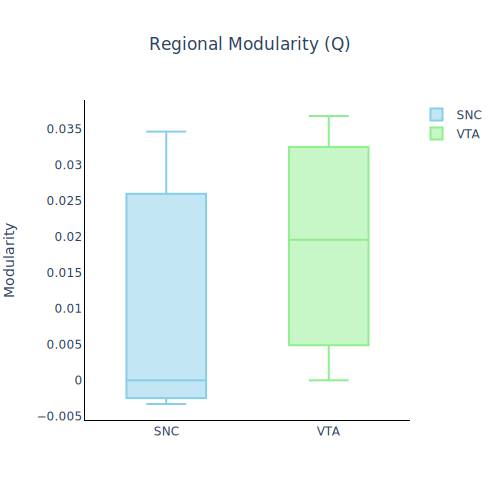

In [25]:

VTAs_modularity = []
SNCs_modularity = []
for i in range(len(dfs)):
    G = nx.from_numpy_array(adjacency_matrices[i])
    partition = nx.community.greedy_modularity_communities(G)
    modularity = nx.community.modularity(G, partition)
    if "VTA" in file_names[i].upper():
        print("VTA Network Modularity", modularity)
        VTAs_modularity.append(modularity)

    elif "SNC" in file_names[i].upper():
        print("SNC Network Modularity:", modularity)
        SNCs_modularity.append(modularity)

data = [SNCs_modularity, VTAs_modularity]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Modularity',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional Modularity (Q)',
    title_x = 0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")


### Path Length

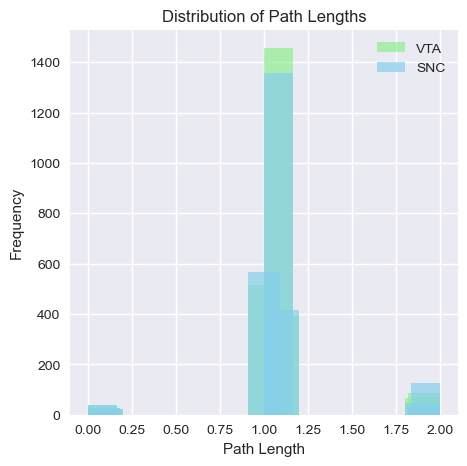

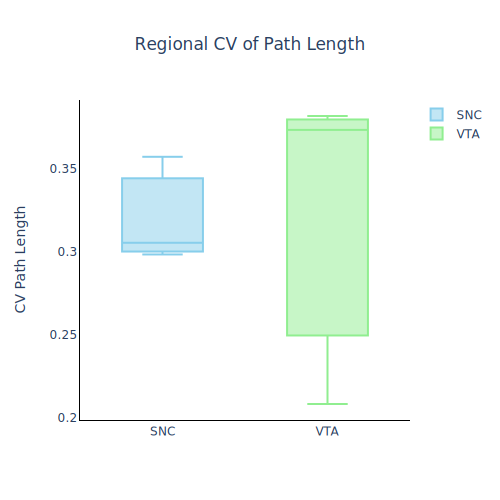

In [33]:
# Create a graph from the adjacency matrix
vflag = False
sflag = False
plt.style.use("seaborn")

VTAs_avg_pl = []
SNCs_avg_pl = []

VTAs_pl_cv = []
SNCs_pl_cv = []

plt.figure(figsize=(5, 5))

for i in range(len(dfs)):
    G = nx.from_numpy_array(adjacency_matrices[i])

    all_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # Flatten the path lengths into a list
    path_lengths_list = [length for source_lengths in all_path_lengths.values() for length in source_lengths.values()]


    # Plot a histogram of the path lengths
    if "VTA" in file_names[i].upper():
        avg_pl = sum(path_lengths_list) / len(path_lengths_list)
        VTAs_avg_pl.append(avg_pl)

        if not vflag:
            plt.hist(path_lengths_list, bins='auto', alpha=0.7, color=box_colors[1], label="VTA")
        else:
            plt.hist(path_lengths_list, bins='auto', alpha=0.7, color=box_colors[1], label="_nolegend_")

        vflag = True
    elif "SNC" in file_names[i].upper():
        avg_pl = sum(path_lengths_list) / len(path_lengths_list)
        SNCs_avg_pl.append(avg_pl)

        color="C1"
        label = "SNC"
        if not sflag:
            plt.hist(path_lengths_list, bins='auto', alpha=0.7, color=box_colors[0], label="SNC")
        else:
            plt.hist(path_lengths_list, bins='auto', alpha=0.7, color=box_colors[0], label="_nolegend_")
        sflag = True

    region_pl = []
    for source_lengths in all_path_lengths.values():
        region_pl.extend(source_lengths.values())
    region_cv = np.std(region_pl) / np.mean(region_pl)

    if "VTA" in file_names[i].upper():
        VTAs_pl_cv.append(region_cv)
    elif "SNC" in file_names[i].upper():
        SNCs_pl_cv.append(region_cv)


    plt.xlabel('Path Length')
    plt.ylabel('Frequency')
    plt.title('Distribution of Path Lengths')

plt.legend()
plt.show()

data = [SNCs_avg_pl, VTAs_avg_pl]
pl_cv_data = [SNCs_pl_cv, VTAs_pl_cv]


fig = go.Figure()

for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])
        ))

fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Path Length',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Path Length Comparison',
    title_x=0.5,
    plot_bgcolor = "white"
)
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show()

fig = go.Figure()

# Add boxplots
for i, d in enumerate(pl_cv_data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='CV Path Length',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional CV of Path Length',
    title_x=0.5,
    plot_bgcolor = "white"
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)

# Show the plot
fig.show("svg")


### Clustering Coefficient and Small-World Coefficient

VTA Small World Coefficient: 0.9957876244415168
VTA Small World Coefficient: 1.000496366291441
VTA Small World Coefficient: 1.000846150593499
SNC Small World Coefficient: 1.006130949290538
SNC Small World Coefficient: 1.010153425119744
SNC Small World Coefficient: 1.0021252217945587


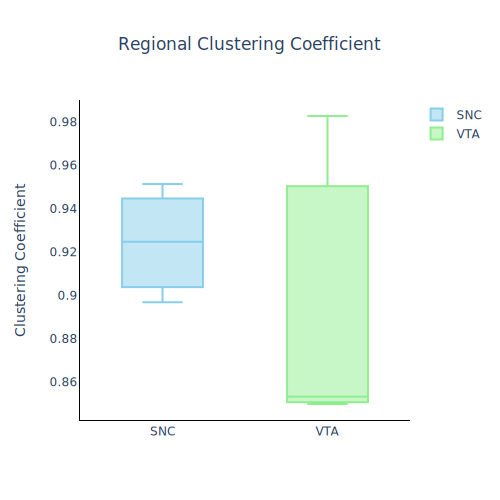

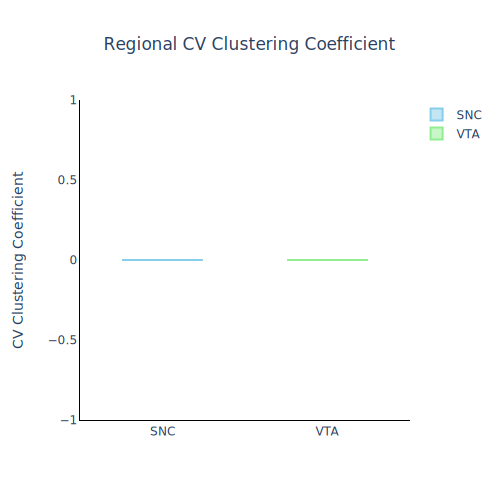

In [27]:
import random

VTAs_cc = []
VTAs_cc_cv = []

VTAs_swc = []
VTAs_swc_cv = []

SNCs_cc = []
SNCs_cc_cv = []

SNCs_swc = []
SNCs_swc_cv = []


for i in range(len(dfs)):

    # Creating network from correlation matrix
    G = nx.from_numpy_array(adjacency_matrices[i])

    # Removing nodes without edges
    G.remove_nodes_from(list(nx.isolates(G)))


    # Extract the largest connected component
    largest_component = max(nx.connected_components(G), key=len)
    G_largest_component = G.subgraph(largest_component)

    # Calculate the small-world coefficient for the largest connected component
    C = nx.average_clustering(G_largest_component)
    L = nx.average_shortest_path_length(G_largest_component)
    n = len(G_largest_component.nodes())

    # Generate a random network with the same number of nodes and edges
    random.seed(134)
    G_random = nx.gnm_random_graph(n, G_largest_component.number_of_edges())

    # Calculate the small-world coefficient
    if nx.is_connected(G_random):
        C_random = nx.average_clustering(G_random)
        L_random = nx.average_shortest_path_length(G_random)

        small_world_coefficient = (C / C_random) / (L / L_random)
        if "VTA" in file_names[i].upper():
            VTAs_cc.append(C)
            VTAs_swc.append(small_world_coefficient)
            print("VTA Small World Coefficient:", small_world_coefficient)
        elif "SNC" in file_names[i].upper():
            SNCs_cc.append(C)
            SNCs_swc.append(small_world_coefficient)

            print("SNC Small World Coefficient:", small_world_coefficient)
   
    region_cc = []
    for component in nx.connected_components(G):
        subgraph = G.subgraph(component)
        cc_values = nx.clustering(subgraph)
        region_cc.append(np.mean(list(cc_values.values())))

    region_cv = np.std(region_cc) / np.mean(region_cc)



    # region_swc = []
    # for component in nx.connected_components(G):
    #     subgraph = G.subgraph(component)
    #     C_subgraph = nx.average_clustering(subgraph)
    #     L_subgraph = nx.average_shortest_path_length(subgraph)

    #     G_random_subgraph = nx.gnm_random_graph(len(subgraph), subgraph.number_of_edges())
    #     C_random_subgraph = nx.average_clustering(G_random_subgraph)
    #     L_random_subgraph = nx.average_shortest_path_length(G_random_subgraph)

    #     small_world_coefficient_subgraph = (C_subgraph / C_random_subgraph) / (L_subgraph / L_random_subgraph)
    #     region_swc.append(small_world_coefficient_subgraph)

    # region_swc_cv = np.std(region_swc) / np.mean(region_swc)


    # Store the regional CV
    if "VTA" in file_names[i].upper():
        VTAs_cc_cv.append(region_cv)
        # VTAs_swc_cv.append(region_swc_cv)

    elif "SNC" in file_names[i].upper():
        SNCs_cc_cv.append(region_cv)
        # SNCs_swc_cv.append(region_swc_cv)




data = [SNCs_cc, VTAs_cc]
cc_cv_data = [SNCs_cc_cv, VTAs_cc_cv]
swc_cv_data = [SNCs_swc_cv, VTAs_swc_cv]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Clustering Coefficient',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional Clustering Coefficient',
    title_x=0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")

fig = go.Figure()

# Add boxplots
for i, d in enumerate(cc_cv_data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='CV Clustering Coefficient',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional CV Clustering Coefficient',
    title_x=0.5,
    plot_bgcolor='white'
)

# Show the plot
fig.show("svg")



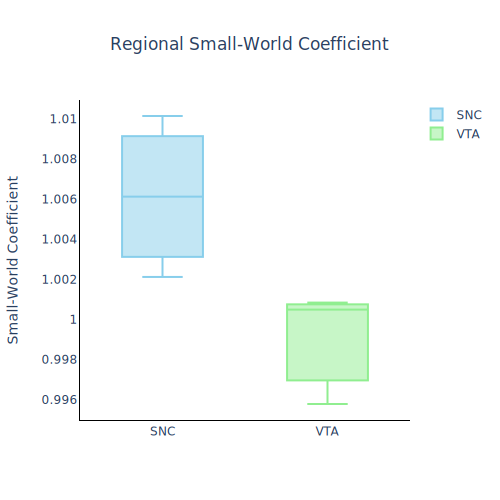

In [28]:
data = [SNCs_swc, VTAs_swc]

fig = go.Figure()

# Add boxplots
for i, d in enumerate(data):
    fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
            color=box_colors[i])))

# Update layout
fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    xaxis=dict(
        tickmode='array',
        tickvals=[0, 1],
        ticktext=['SNC', 'VTA'],
        showline=True, linewidth=1, linecolor='black'
    ),
    yaxis=dict(
        title='Small-World Coefficient',
        showline=True, linewidth=1, linecolor='black'
    ),
    title='Regional Small-World Coefficient',
    title_x=0.5,
    plot_bgcolor="white"
)

fig.show("svg")

# fig = go.Figure()

# # Add boxplots
# for i, d in enumerate(swc_cv_data):
#     fig.add_trace(go.Box(y=d, name=['SNC', 'VTA'][i], marker=dict(
#             color=box_colors[i])))

# # Update layout
# fig.update_layout(
#     xaxis=dict(
#         tickmode='array',
#         tickvals=[0, 1],
#         ticktext=['SNC', 'VTA'],
#     ),
#     yaxis=dict(
#         title='CV Clustering Coefficient',
#     ),
#     title='Regional CV Clustering Coefficient',

# )

# # Show the plot
# fig.show()

### Visualizing Networks

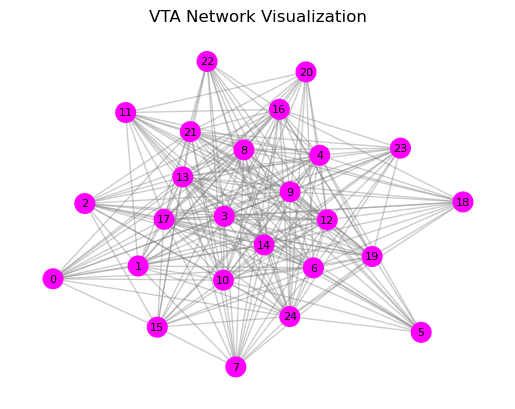

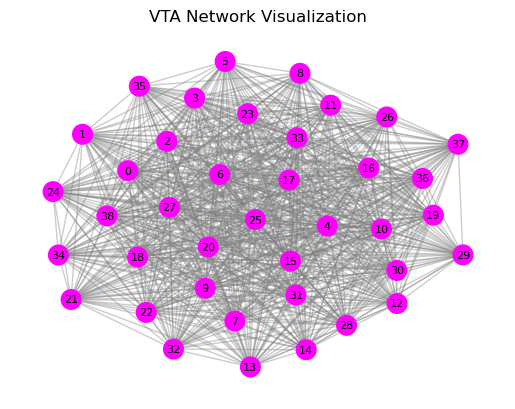

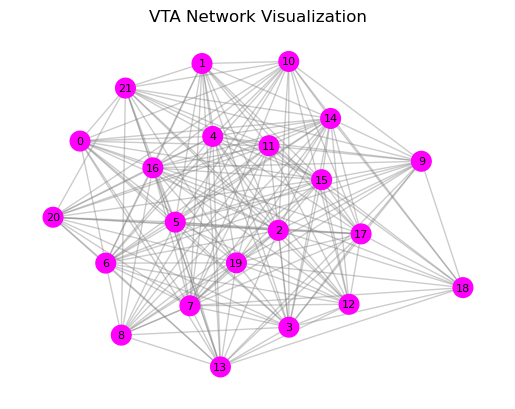

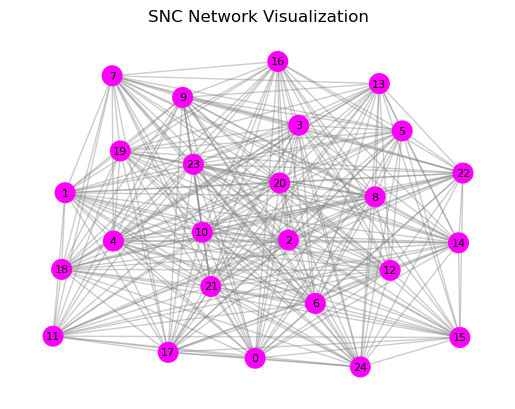

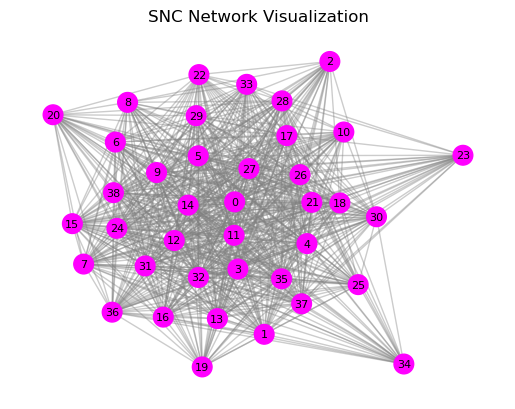

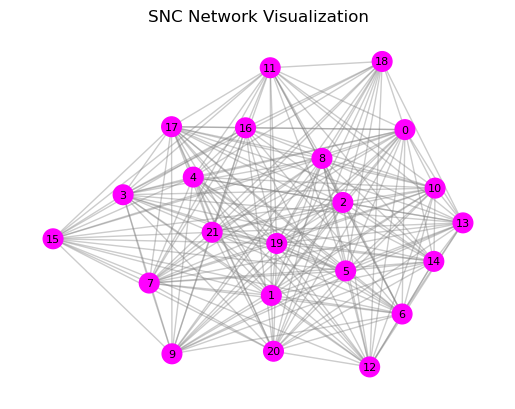

In [47]:
for df_i in range(len(dfs)):
    # Create a graph from the adjacency matrix
    G = nx.from_numpy_array(adjacency_matrices[df_i])

    # Removing nodes without edges
    G.remove_nodes_from(list(nx.isolates(G)))


    # Calculate all pairs shortest path lengths
    all_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

    # Calculate the maximum path length for scaling the colors
    max_path_length = max([max(lengths.values()) for lengths in all_path_lengths.values()])

    cmap = plt.cm.get_cmap('cool') 

    pos = nx.spring_layout(G)  # Layout algorithm to determine node positions

    # Iterate over nodes and assign colors based on path lengths
    node_colors = []
    for node in G.nodes():
        path_length = sum(all_path_lengths[node].values())
        color = cmap(path_length / max_path_length)
        node_colors.append(color)

    nx.draw_networkx_nodes(G, pos=pos, node_color=node_colors, node_size=200)

    nx.draw_networkx_edges(G, pos=pos, edge_color='gray', alpha=0.4)
    nx.draw_networkx_labels(G, pos=pos, font_color='black', font_size=8)

    # Customize the plot
    if "VTA" in file_names[df_i].upper():
        plt.title('VTA Network Visualization')
    elif "SNC" in file_names[df_i].upper():
        plt.title('SNC Network Visualization')
    plt.axis('off')

    # Display the plot
    plt.show()
